# Roadmap

The goal of this notebook is to provide an example of how compute basin average rainrate for a storm given gridded rainfall fields and a shapefile of the basin

  1. Read gridded rainfall fields from NetCDF files
  2. Accumulate gridded data
  3. Read in shapefile
  4. Reproject to match rainfall fields
  5. Use binary check to see if grids fall within basin
  6. Calculate percentage of each grid cell that falls within the basin
  7. Use weights to get basin averaged storm total rain
  8. Use weights to generate a time series of basin-averaged rain
  
 Notebook created by Princeton Hydrology Research Team, Enhanced by Erin Gray to work for Thesis

Before getting started, set up your environment with all the necessities to run this notebook. To create this environment just run **`$ conda env create -f environment.yml`** where **`environment.yml`** is a file containing the following:

## Specify the basin of interest

In [2]:
 basinname = "Top"
# basinname = "Bottom"
# basinname = "TiberRun"

In [3]:
!sudo python2 -m pip install --upgrade ipykernel
!sudo python2 -m ipykernel install

'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\python\Anaconda3\lib\site-packages\xarray\core\utils.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping, MutableMapping, MutableSet
C:\Users\python\Anaconda3\lib\site-packages\xarray\core\utils.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping, MutableMapping, MutableSet
C:\Users\python\Anaconda3\lib\site-packages\xarray\core\utils.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping, MutableMapping, MutableSet
C:\Users\python\Anaconda3\lib\site-packages\xarray\core\utils.py:11: DeprecationWarning: Using or importing the ABCs from 'collection

## Read gridded rainfall fields from NetCDF files

In [5]:
import os
import numpy as np
import pandas as pd
import pyart

In [6]:
grid_paths = ['2016/{f}'.format(f=f) for f in os.listdir('2016/') if '.grid' in f]
grid_paths.sort()

In [27]:
grid_paths

['2016/KLWX20160730_180049.grid',
 '2016/KLWX20160730_180433.grid',
 '2016/KLWX20160730_180818.grid',
 '2016/KLWX20160730_181202.grid',
 '2016/KLWX20160730_181546.grid',
 '2016/KLWX20160730_181945.grid',
 '2016/KLWX20160730_182344.grid',
 '2016/KLWX20160730_182757.grid',
 '2016/KLWX20160730_183155.grid',
 '2016/KLWX20160730_183608.grid',
 '2016/KLWX20160730_184037.grid',
 '2016/KLWX20160730_184450.grid',
 '2016/KLWX20160730_184919.grid',
 '2016/KLWX20160730_185332.grid',
 '2016/KLWX20160730_185801.grid',
 '2016/KLWX20160730_190229.grid',
 '2016/KLWX20160730_190657.grid',
 '2016/KLWX20160730_191126.grid',
 '2016/KLWX20160730_191554.grid',
 '2016/KLWX20160730_192023.grid',
 '2016/KLWX20160730_192452.grid',
 '2016/KLWX20160730_192920.grid',
 '2016/KLWX20160730_193348.grid',
 '2016/KLWX20160730_193816.grid',
 '2016/KLWX20160730_194245.grid',
 '2016/KLWX20160730_194713.grid',
 '2016/KLWX20160730_195142.grid',
 '2016/KLWX20160730_195611.grid',
 '2016/KLWX20160730_200039.grid',
 '2016/KLWX201

In [34]:
m = pyart.io.read_grid(grid_paths[150])
rain = np.ma.filled(m.fields['RRComp(KDP)']['data'][0],0)

In [39]:
grid_paths[0:2]

['2016/KLWX20160730_180049.grid', '2016/KLWX20160730_180433.grid']

In [81]:
nx = 400
ny = 400

rain = np.zeros((ny, nx))
rain_mask = np.zeros((ny, nx))

for i in range(1,len(grid_paths)):
    grid_path = grid_paths[i]
    prev_path = grid_paths[i-1]
    part1, part2 = grid_path.split('_')
    year1, month1, day1 = int(part1[9:13]), int(part1[13:15]), int(part1[15:17])
    hour1, min1, sec1 = int(part2[0:2]), int(part2[2:4]), int(part2[4:6])
    
    t1 = pd.Timestamp(year=year1, month=month1, day=day1, hour=hour1, minute=min1, second=sec1)
    part1, part2 = prev_path.split('_')
    year2, month2, day2 = int(part1[9:13]), int(part1[13:15]), int(part1[15:17])
    hour2, min2, sec2 = int(part2[0:2]), int(part2[2:4]), int(part2[4:6])
    
    t2 = pd.Timestamp(year=year2, month=month2, day=day2, hour=hour2, minute=min2, second=sec2)
    
    delta_t_hours = ((t1-t2).seconds)/60./60.
    
    m = pyart.io.read_grid(grid_path)
    #rain
    rain_rate = np.ma.filled(m.fields['RRComp(KDP)']['data'][0], 0)
    
    rain_acc_mm = rain_rate*delta_t_hours
    
    rain += rain_acc_mm
    
    rain_mask += m.fields['RRComp(KDP)']['data'][0].mask

We will find it useful to know both the edges of the grid cells and the centers of the grid cells, lets just be sure we know which ones we are looking at at any given time. We will call them elat, elon, and clat, clon to keep track.

In [82]:
elon, elat = m.get_point_longitude_latitude(edges=True)
clon, clat = m.get_point_longitude_latitude()

## Read in Shapefile

In [83]:
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
shpfile= str(basinname) + '/' + 'globalwatershed.shp'
shp = Reader(shpfile)

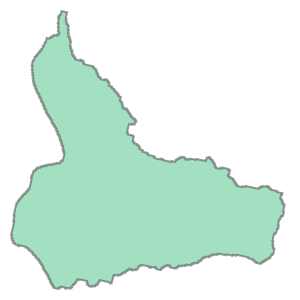

In [85]:
geoms = shp.geometries()
polygon = cascaded_union(list(geoms))
polygon

Let's keep track of the watershed area in km

In [86]:
basin_area = polygon.area/1000000
basin_area


3.9904212946017354

Check out the projection and try placing the shapefile over the data.

In [87]:
# this can check the shapefile properties, including its projection. 
# Remember to change the shapefile name!
# cat Shapefiles/MooresRun/Projected_layers/globalwatershed.prj

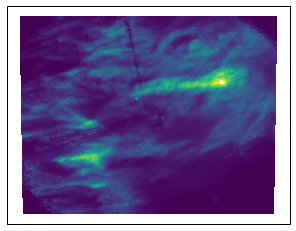

In [88]:
shape_feature = ShapelyFeature(shp.geometries(),
                               ccrs.UTM(18),
                               facecolor='none',
                               edgecolor='white')

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(shape_feature)
#ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
ax.pcolormesh(elon, elat, rain, transform=ccrs.PlateCarree())

Reproject shapefile from original coordinate system into latlon to match gridded rainfall

In [89]:
from functools import partial
import pyproj
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:26918'), # source coordinate system  # can activate gdalenv and view shapefile info: "ogrinfo -so globalwatershed.shp globalwatershed". Will display something like: AUTHORITY["EPSG","26918"]]
    pyproj.Proj(init='epsg:4326')) # destination coordinate system
g2 = transform(project, polygon)  # apply projection

We can plot this over the original data to see whether it looks reasonable

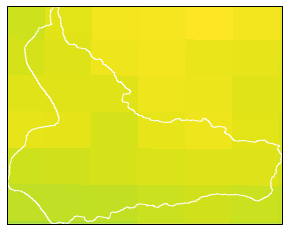

In [90]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(shape_feature)
ax.pcolormesh(clon, clat, rain, transform=ccrs.PlateCarree())
ax.set_extent([g2.bounds[0], g2.bounds[2], g2.bounds[1], g2.bounds[3]])

## Use a binary search to check if the center of each cell is in the basin
This idea is based on [this blog post](https://ocefpaf.github.io/python4oceanographers/blog/2015/08/17/shapely_in_polygon/)

In [91]:
def inpolygon(polygon, xp, yp):
    return np.array([Point(x, y).intersects(polygon) for x, y in zip(xp, yp)],
                    dtype=np.bool)

mask1d = inpolygon(g2, clon.ravel(), clat.ravel())
mask2d = mask1d.reshape(clon.shape)

In [92]:
basin_rain = np.ma.masked_array(rain, ~mask2d)

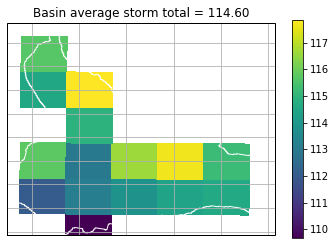

In [93]:
ax = plt.axes(projection=ccrs.PlateCarree())
c = ax.pcolormesh(elon, elat, basin_rain)
ax.set_extent([g2.bounds[0], g2.bounds[2], g2.bounds[1], g2.bounds[3]])
ax.add_feature(shape_feature)
ax.gridlines()
plt.colorbar(c)
plt.title('Basin average storm total = {r:1.2f}'.format(r=basin_rain.mean()));

## Calculate percentages of grid cells
We need to figure out how to do another mask where the resolution is finer. I took some ideas from [this SO question](http://stackoverflow.com/questions/14697442/faster-way-of-polygon-intersection-with-shapely). First we will get a rough box arouond the shapefile to limit the number of queries that we need to perform. 

In [94]:
buf = .01

bool_a = ((clon > g2.bounds[0]-buf) & (clon < g2.bounds[2]+buf) &
          (clat > g2.bounds[1]-buf) & (clat < g2.bounds[3]+buf))

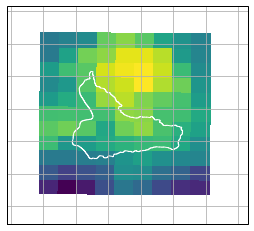

In [95]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(shape_feature)
ax.gridlines()
ax.pcolormesh(elon, elat, np.ma.masked_array(rain, ~bool_a))
ax.set_extent([g2.bounds[0]-buf*2, g2.bounds[2]+buf*2, g2.bounds[1]-buf*2, g2.bounds[3]+buf*2])

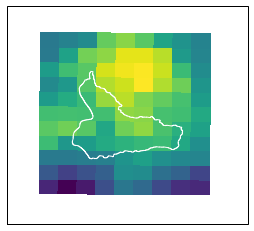

In [96]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(shape_feature)
ax.pcolormesh(elon, elat, np.ma.masked_array(rain, ~bool_a))
ax.set_extent([g2.bounds[0]-buf*2, g2.bounds[2]+buf*2, g2.bounds[1]-buf*2, g2.bounds[3]+buf*2])

That worked pretty well! So now we will take just this subset of gridcells and make each one into a shapely.Polygon object. Once we have a list of these Polygons, we can calculate what percentage of each grid cell intersects with our reprojected basin. 

In [97]:
np.shape(bool_a[bool_a==True])

(99,)

In [98]:
# %%time
mp = []
for iy, ix in zip(*np.where(bool_a)):
    mp.append(Polygon([(elon[iy,ix], elat[iy,ix]), 
                       (elon[iy,ix+1], elat[iy,ix+1]),
                       (elon[iy+1,ix+1], elat[iy+1,ix+1]),
                       (elon[iy+1,ix], elat[iy+1,ix])]))

weights = np.array([g2.intersection(p).area/p.area for p in mp])
print(weights)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.2806012  0.43541671 0.12610151 0.02403823
 0.         0.         0.         0.         0.1615512  0.94155193
 1.         1.         0.95771583 0.78838039 0.31761938 0.
 0.         0.06389674 0.92986283 1.         1.         1.
 0.83272653 0.34391321 0.         0.         0.         0.31167176
 1.         0.51722452 0.26094318 0.03825943 0.         0.
 0.         0.         0.72673939 0.8985402  0.0779566  0.
 0.         0.         0.         0.         0.         0.65601019
 0.11883859 0.         0.         0.         0.         0.
 0.         0.         0.06157755 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

Cool! So that wasn't the fastest thing in the world but not so bad either. And now we have all the weights that we need going forward. So if we subset our rain in the same way, all we need to do is multiply by the weights, sum our weighted values, and then divide by the basin area in km to get basin average storm rain.

In [99]:
weights.shape

(99,)

In [100]:
z = np.array([rain[iy,ix] for iy, ix in zip(*np.where(bool_a))])
weighted_rain = z*weights

storm_total = weighted_rain.sum()/basin_area
print('Basin average storm total = {r:1.2f}'.format(r=storm_total))

Basin average storm total = 456.35


In [135]:
number_of_pixels = basin_area*4
# because pixels are 1/2km2 and basin area is in km2
# per MMC 2/14/2020

In [139]:
totals = []
times = []
for grid_path in grid_paths:
    m = pyart.io.read_grid(grid_path)
    rain = np.ma.filled(m.fields['RR(Z)']['data'][0], 0)
    z = np.array([rain[iy,ix] for iy, ix in zip(*np.where(bool_a))])
    weighted_rain = z*weights
    t_tot = weighted_rain.sum()/number_of_pixels
    totals.append(t_tot)
    times.append(pd.Timestamp(grid_path.split('/')[-1][4:19].replace('_', ' ')))

time_series = pd.Series(index=times, data=totals)

In [140]:
time_series.idxmax()

Timestamp('2016-07-30 23:32:57')

In [107]:
rtime_ser = time_series.resample('1Min').mean()  #[100:200]
#rtime_ser = time_series.resample('1Min').bfill()[100:200]
#rtime_ser = time_series.interpolate(method='time', axis=0)

rtime_ser = rtime_ser.interpolate(method = 'index')

In [108]:
type(rtime_ser)

pandas.core.series.Series

In [109]:
rtime_ser

2016-07-30 18:00:00    2.079477
2016-07-30 18:01:00    3.854844
2016-07-30 18:02:00    5.630212
2016-07-30 18:03:00    7.405579
2016-07-30 18:04:00    9.180946
                         ...   
2016-07-31 02:05:00    0.156779
2016-07-31 02:06:00    0.159478
2016-07-31 02:07:00    0.160890
2016-07-31 02:08:00    0.162301
2016-07-31 02:09:00    0.163713
Freq: T, Length: 490, dtype: float64

In [110]:
index = pd.date_range('2016-02-24 00:02:00', '2016-02-25 23:58:00', freq = 'M')
print(index)
time_series.reindex(index)
print(time_series)

DatetimeIndex([], dtype='datetime64[ns]', freq='M')
2016-07-30 18:00:49    2.079477
2016-07-30 18:04:33    9.180946
2016-07-30 18:08:18    3.599358
2016-07-30 18:12:02    0.311817
2016-07-30 18:15:46    0.054557
                         ...   
2016-07-31 01:54:19    0.122949
2016-07-31 01:58:18    0.113512
2016-07-31 02:02:16    0.148682
2016-07-31 02:06:01    0.159478
2016-07-31 02:09:47    0.163713
Length: 112, dtype: float64


In [111]:
ts_outfn = str(basinname) + '/' + str(basinname) + '_BasinAverageRR.csv'
time_series.to_csv(ts_outfn)

C:\Users\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


Text(0, 0.5, 'Basin-averaged Rain [mm]')

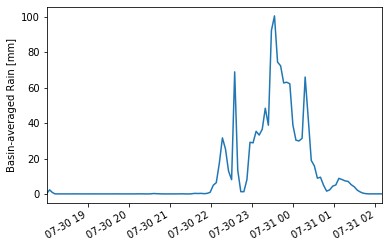

In [141]:
time_series.plot()
plt.ylabel('Basin-averaged Rain [mm]')